# Bootstrap models

- Create sample of estimates with selection based on the probality of error

In [ ]:
library(haven)
library(sdazar)
library(brms)
options(repr.plot.width=6, repr.plot.height=4)
# options(mc.cores = parallel::detectCores()-2)

In [ ]:
library(doParallel)

In [3]:
# create sample of estimates (10 for testing)

seed = 102330
df = data.table(read_dta('../data/FOR_BOOTSTRAP_FINAL_NOV_19_2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

In [4]:
dim(df[year>=1900])

[1] 1874  169

In [5]:
# head(df)

In [6]:
df = melt(df, id_vars=c('ctry', 'year'), measure = patterns("^Ex", "^pr"), value.name = c("le", "pr"))
df = df[!is.na(le)]
setorder(df, ctry, year)

In [7]:
# merge covariates
covs = fread('../data//featured_LE_data.csv')

In [8]:
covs[, c("Ex", "y", "wy", "max_le") := NULL]

In [9]:
df = merge(df, covs, on=c('ctry','year'))

# Checks

In [51]:
test = df[, .(min_le=min(le), max_le=max(le), min_pr=min(pr), max_pr=max(pr)), by=.(ctry, year)]

In [52]:
test[, diff_years := max_le - min_le]
test[, diff_prob := max_pr - min_pr]

In [53]:
summary(test)

         ctry           year          min_le          max_le     
 Cuba      : 171   Min.   :1841   Min.   :10.03   Min.   :29.19  
 Chile     : 158   1st Qu.:1924   1st Qu.:34.20   1st Qu.:36.36  
 Costa_Rica: 148   Median :1956   Median :50.44   Median :52.38  
 Argentina : 143   Mean   :1951   Mean   :50.32   Mean   :52.17  
 Brazil    : 140   3rd Qu.:1984   3rd Qu.:66.34   3rd Qu.:67.01  
 Peru      : 136   Max.   :2013   Max.   :79.75   Max.   :79.75  
 (Other)   :1227                                                 
     min_pr           max_pr         diff_years       diff_prob      
 Min.   :0.5000   Min.   :0.6500   Min.   : 0.000   Min.   :0.00000  
 1st Qu.:0.6500   1st Qu.:0.6500   1st Qu.: 0.000   1st Qu.:0.00000  
 Median :0.6500   Median :0.9500   Median : 0.000   Median :0.00000  
 Mean   :0.7648   Mean   :0.8461   Mean   : 1.842   Mean   :0.08132  
 3rd Qu.:0.9500   3rd Qu.:0.9500   3rd Qu.: 1.374   3rd Qu.:0.10000  
 Max.   :0.9500   Max.   :0.9500   Max.   :39.985   

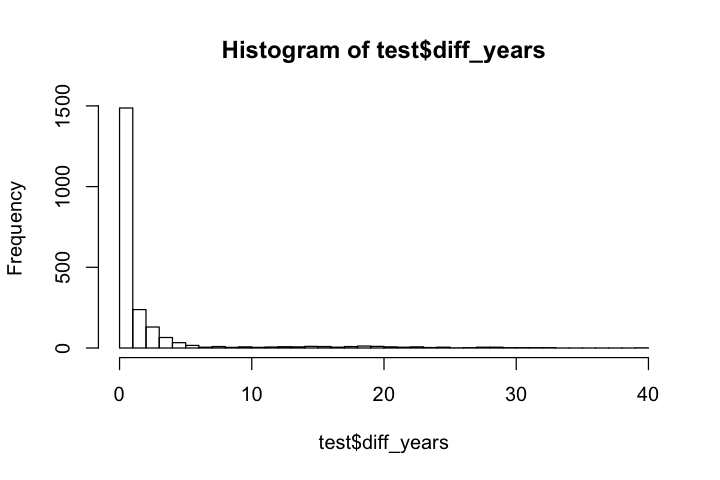

In [54]:
hist(test$diff_years, breaks=40)

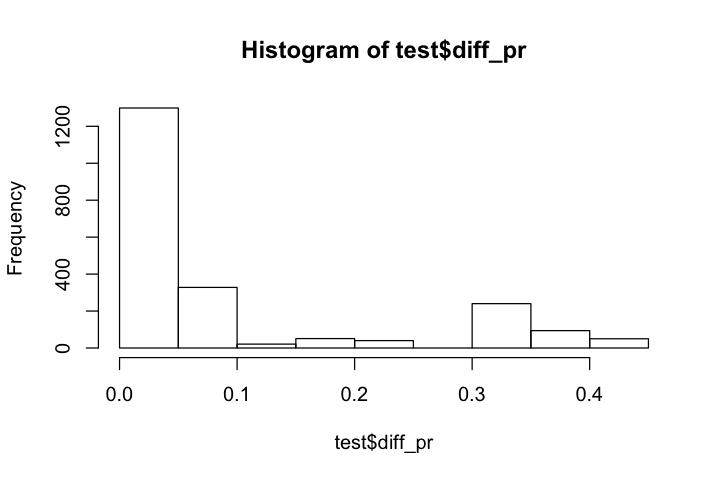

In [55]:
hist(test$diff_pr, breaks=10)

In [56]:
table(test$diff_years>5) / sum(table(test$diff_years>5))


     FALSE       TRUE 
0.91992463 0.08007537 

In [134]:
# test

# Sampling

In [10]:
df = df[year >= 1900]
df[, upr := 1 / .N, .(ctry, year)]
df[, spr := pr / sum(pr), by=.(ctry, year)]

df[, N := .N, .(ctry, year)]
sample_size = 1000

In [11]:
set.seed = seed
samples = df[,.SD[ sample(.N, sample_size, replace=TRUE, prob=spr)], by = .(ctry,year)]

samples[, sample_index := 1:.N, by=.(ctry, year)]
dim(samples)

[1] 1848000      33

In [12]:
set.seed = seed
usamples = df[,.SD[ sample(.N, sample_size, replace=TRUE, prob=upr)], by = .(ctry,year)]

usamples[, sample_index := 1:.N, by=.(ctry, year)]
dim(usamples)

[1] 1848000      33

In [13]:
fwrite(samples, '../data/bs_samples.csv', row.names=FALSE)
fwrite(usamples, '../data/bs_samples_uniform.csv', row.names=FALSE)

In [142]:
print(names(usamples))

 [1] "ctry"         "year"         "variable"     "le"           "pr"          
 [6] "gdp_pc"       "urban"        "lit"          "water"        "sewage"      
[11] "elec"         "us_aid"       "tfr"          "gyear"        "ctry_year"   
[16] "igdp_pc"      "iurban"       "ilit"         "itfr"         "iwater"      
[21] "isewage"      "ielec"        "igdp_log"     "iurban_log"   "ilit_log"    
[26] "iwater_log"   "isewage_log"  "ielec_log"    "zyear"        "upr"         
[31] "spr"          "N"            "sample_index"


In [98]:
dim(samples[sample_index==10])

[1] 1848   33

In [99]:
1848*100

[1] 184800

# Explore distribution of stacking model weight

- Using models summarized in the file description, shift_1900_stacking.csv
- Variability of weights is rather small

In [55]:
w = data.table(readRDS('output/weights.rds'))

In [56]:
options(repr.plot.width=6, repr.plot.height=4)

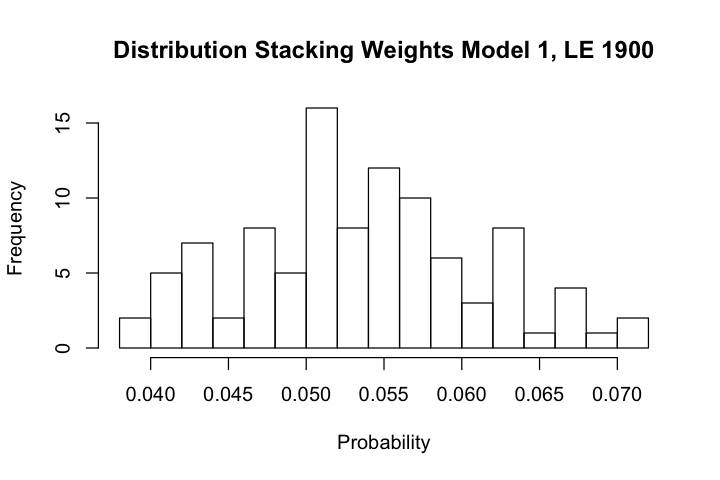

In [57]:
hist(w$model1, main='Distribution Stacking Weights Model 1, LE 1900', 
     xlab='Probability', breaks = 20)

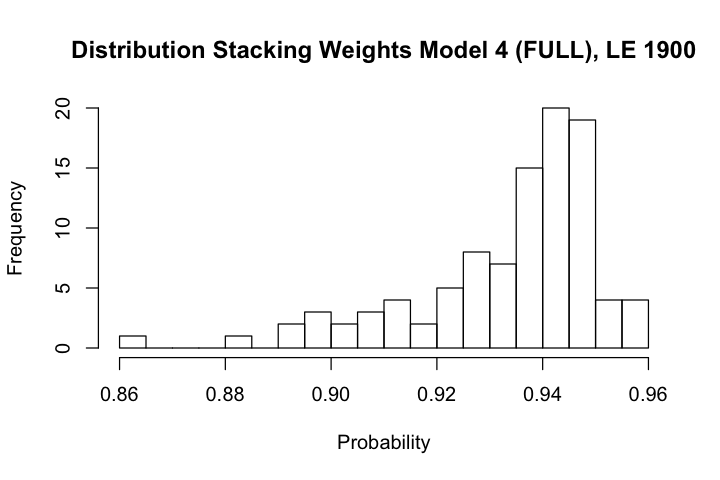

In [58]:
hist(w$model4, main='Distribution Stacking Weights Model 4 (FULL), LE 1900', 
     xlab='Probability', breaks = 30)

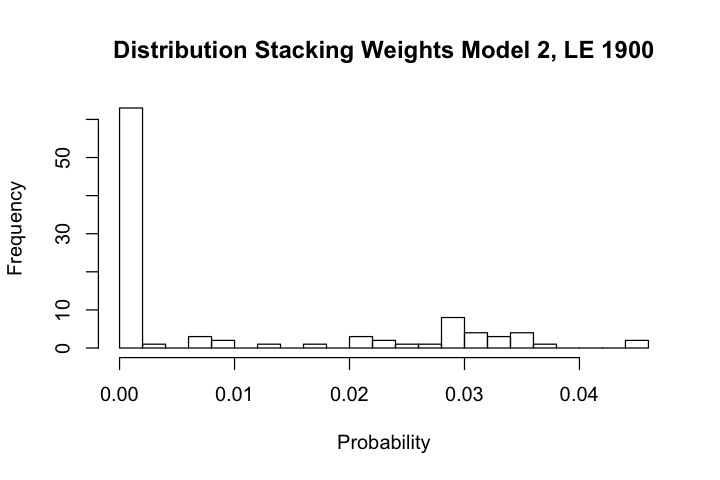

In [59]:
hist(w$model2, main='Distribution Stacking Weights Model 2, LE 1900', 
     xlab='Probability', breaks = 20)

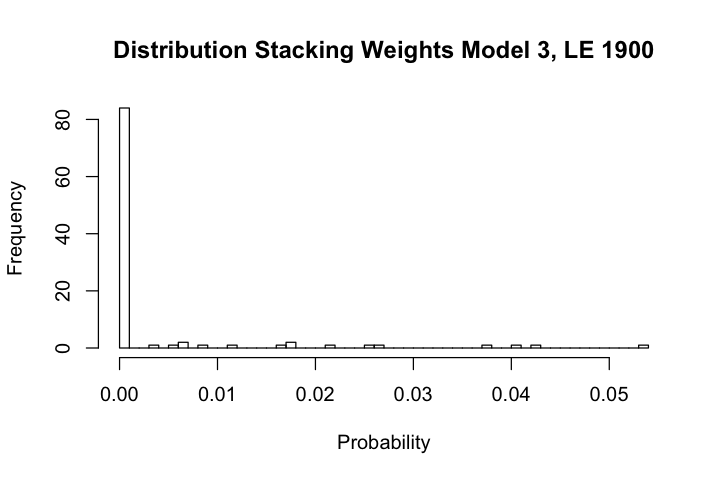

In [60]:
hist(w$model3, main='Distribution Stacking Weights Model 3, LE 1900', 
     xlab='Probability', breaks = 50)

# Read list with shifts

In [4]:
library(data.table)
s = data.table(readRDS('../lstat/output/shifts_1900.rds'))

In [5]:
table(s$sample_index)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   40    41    42    43    44    45    46    47    48    49    50    51    52 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   53    54    55    56    57    58    59    60    61    62    63    64    65 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   66    67    68    69    70    71    72    73    74    75    76    77    78 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   79    80    81    82    83    84    85    86    

In [7]:
fwrite(s, '../lstat/output/bs_shift_1900.csv', row.names=FALSE)

In [1]:
# s[sample_index==1]

In [147]:
s = data.table(readRDS('../lstat/output/shifts_1900_uniform.rds'))
table(s$sample_index)
fwrite(s, '../lstat/output/bs_shift_1900_unifom.csv', row.names=FALSE)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   40    41    42    43    44    45    46    47    48    49    50    51    52 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   53    54    55    56    57    58    59    60    61    62    63    64    65 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   66    67    68    69    70    71    72    73    74    75    76    77    78 
34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 34500 
   79    80    81    82    83    84    85    86    

# Checks distributions

In [58]:
df1 = fread('../lstat/output/bs_shift_1900.csv')
df2 = fread('../lstat/output/bs_shift_1900_uniform.csv')

In [62]:
table(df1[ctry=='Argentina' & year == 1950 & segment == '1950'][, sample_index])


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 

In [66]:
summary(df1[ctry=='Argentina' & year == 1950 & segment == '1950', shift_pred])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.448   2.702   3.822   3.669   4.743   8.422 

In [65]:
summary(df2[ctry=='Argentina' & year == 1950 & segment == '1950', shift_pred])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.076   2.640   3.808   3.666   4.788   8.993 

In [27]:
test1= df1[, .(average_shift_pred1=mean(shift_pred), N1=.N), .(ctry, year, segment)]
test2= df2[, .(average_shift_pred2=mean(shift_pred), N2=.N), .(ctry, year, segment)]

In [30]:
dim(test2)

[1] 345   5

In [32]:
test = merge(test1, test2, on=c('ctry', 'year', 'segment'))

In [50]:
test[, diff := abs(average_shift_pred1-average_shift_pred2)]

In [56]:
summary(test[average_shift_pred1 != 0, abs(average_shift_pred1)])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.04818  2.60461  4.64388  7.12355 10.48887 29.25197 

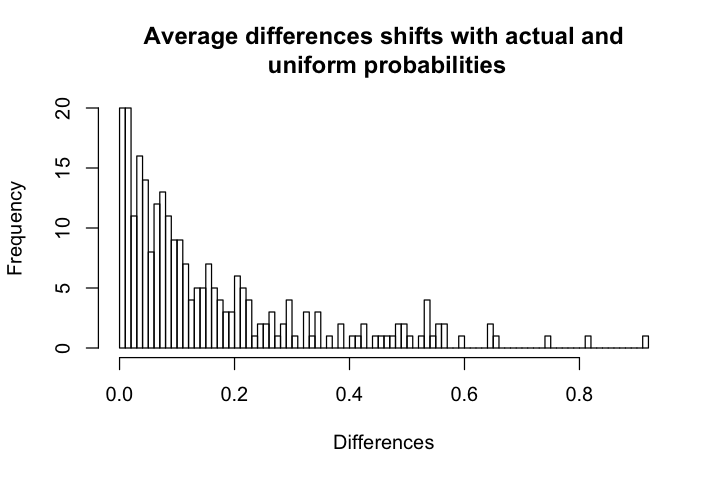

In [53]:
hist(test[average_shift_pred1 != 0, diff], breaks=100, 
    main='Average differences shifts with actual and\n uniform probabilities', 
    xlab='Differences')

In [54]:
summary(test[average_shift_pred1 != 0, diff])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0005012 0.0366289 0.0927578 0.1583077 0.2105838 0.9112573 

In [57]:
round(0.1583077/7.12355, 2)

[1] 0.02